In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Loading the datasets

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/saigouravsahoo/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1


In [3]:
true_df = pd.read_csv('/Users/saigouravsahoo/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1/True.csv')
fake_df = pd.read_csv('/Users/saigouravsahoo/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1/Fake.csv')

In [4]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
import re

# Collecting information to make rule-based Tokenizer

The purpose of the few cells below is to collect some information so that we have an idea as to how much and what all textual pieces are to be included for "editing" the corpus in a rule-based manner.

In [7]:
def extract_contractions(df, column):
    contraction_set = set()
    for title in df[column].dropna():
        words = title.split()
        for word in words:
            word_clean = re.sub(r'[^\w\']', '', word)  # keep apostrophes
            if re.search(r"\w+'\w+", word_clean):  # apostrophe in the middle
                contraction_set.add(word_clean.lower())
    return sorted(contraction_set)

# run on true_df
contractions_list = extract_contractions(true_df, "title")
print("Unique contractions found:")
print(contractions_list)


Unique contractions found:
["'america's", "'bernie's", "'can't", "'children's", "'china's", "'didn't", "'doesn't", "'don't", "'fool's", "'godman's'", "'he's", "'i'm", "'it's", "'kremlin's", "'let's", "'people's", "'russia's", "'shouldn't", "'there's", "'wasn't", "'we'll", "'we're", "'what's", "'women's", "'won't", "'world's", "'wouldn't", "'you're", "2017's", "5star's", "abe's", "activist's", "administration's", "administrator's", "adviser's", "afghanistan's", "africa's", "agency's", "aide's", "airport's", "alabama's", "alaska's", "algeria's", "alibaba's", "alwaleed's", "amazon's", "ambassador's", "america's", "amsterdam's", "angola's", "ankara's", "anti'sanctuary'", "aoun's", "apple's", "arabia's", "aren't", "argentina's", "army's", "asia's", "assad's", "astron's", "australia's", "austria's", "avocet's", "babis's", "baby's", "bahrain's", "bali's", "ban's", "bangladesh's", "bank's", "banker's", "bannon's", "barca's", "barron's", "barzani's", "baseball's", "batista's", "beijing's", "bel

In [8]:
def extract_clean_repeated_char_words(df_list, column):
    repeated_words = set()
    pattern = re.compile(r'(.)\1{3,}')  # match any char repeated >= 4 times

    for df in df_list:
        for title in df[column].dropna():
            words = title.split()
            for word in words:
                word_clean = re.sub(r'[^\w]', '', word)  # remove punctuation
                # skip if contains any digits
                if pattern.search(word_clean.lower()) and word_clean.isalpha():
                    repeated_words.add(word_clean.lower())

    return sorted(repeated_words)

clean_repeated_words = extract_clean_repeated_char_words([true_df, fake_df], "title")
print("Cleaned list of repeated-character words (no digits):")
print(clean_repeated_words)


Cleaned list of repeated-character words (no digits):
['aloooone', 'baaaaack', 'baaackkkk', 'republicanswaaaaaaaa']


In [9]:
# prepare necessary dictionaries to handle tokenizing requirements

# expanding the contractions:
contractions = {
  "don't": "do not",
  "doesn't": "does not",
  "can't": "cannot",
  "won't": "will not",
  "i'm": "i am",
  "you're": "you are",
  "he's": "he is",
  "she's": "she is",
  "it's": "it is",
  "that's": "that is",
  "there's": "there is",
  "he'll": "he will",
  "she'll": "she will",
  "it'll": "it will",
  "they're": "they are",
  "we're": "we are",
  "didn't": "did not",
  "hasn't": "has not",
  "isn't": "is not",
  "aren't": "are not",
  "wasn't": "was not",
  "weren't": "were not",
  "wouldn't": "would not",
  "couldn't": "could not",
  "shouldn't": "should not",
  "could've" : "could have",
  "gov't": "government",
  "let's": "let us",
  "what's": "what is",
  "who's": "who is",
}

# tokenize the repeated characters
repeated_characters = {
  "aloooone" : "alo <REPEAT:4> ne",
  "baaaaack" : "ba <REPEAT:5> ck",
  "baaackkkk" : "ba <REPEAT:3 ck <REPEAT:4>",
  "republicanswaaaaaaaa" : "republicanswa <REPEAT:8>"
}

# tokenize emoticons 
emoticons = {
  r":\)+": "<EMOTICON:happy>",
  r":D+": "<EMOTICON:happy>",
  r":\(+": "<EMOTICON:sad>",
  r":P+": "<EMOTICON:playful>",
  r";\)+": "<EMOTICON:smug>",
  r":O+": "<EMOTICON:surprised>",
  r":\/+": "<EMOTICON:unsure>",
  r":'\(+": "<EMOTICON:crying>"
}

dicts = [contractions, repeated_characters, emoticons]

# POS Tagger and Stemmer

In [13]:
class MiniPOSTagger:
    def __init__(self):
        self.articles = {'a', 'an', 'the', 'A', 'An', 'The'}
        # setup suffix rules
        self.rules = {
            'VERB': ['ing', 'ed', 'pt', 'ung', 'en', 'ise', 'ize', 'ate'],
            'ADV': ['ly'],
            'ADJ': ['er', 'est', 'less', 'ful', 'ous', 'able', 'al', 'ish', 'ian', 'ic', 'i', 'y'],
            'NOUN': ['ion', 'age', 'al', 'dom', 'ee', 'hood', 'ism', 'ist', 'ment', 'ness', 'ry', 'ship']
        }

    def tag_word(self, word):
        if word in self.articles:
            return 'ART'
        if word[0].isupper() or word.isupper():
            return 'NOUN'
        lowered = word.lower()
        for tag, suffixes in self.rules.items():
            for suffix in suffixes:
                if lowered.endswith(suffix) and lowered not in ["after", "over", "under"]:
                    return tag
        return 'UNK'

    def tag_sentence(self, sentence):
        words = sentence.split()
        return [(word, self.tag_word(word)) for word in words]

class RuleBasedLemmatizer:
    def __init__(self, pos_tagger):
        self.tagger = pos_tagger

    def lemmatize_word(self, word, pos, dicts):
        # tokenize first before lemmatizing
        for d in dicts:
            if word in d:
                return d[word]
    
        lowered = word.lower()

        if pos == 'VERB':
            for suffix in ['ing', 'ed', 'pt', 'ung', 'en', 'ise', 'ize', 'ate']:
                if lowered.endswith(suffix):
                    return lowered[:-len(suffix)]
        elif pos == 'ADJ':
            for suffix in ['ness', 'ful', 'ous', 'able', 'al', 'ish', 'ian', 'ic', 'i', 'er', 'est', 'y']:
                if lowered.endswith(suffix) and lowered not in ["after", "under", "over"]:
                    return lowered[:-len(suffix)]
        elif pos == 'ADV':
            if lowered.endswith('ly'):
                return lowered[:-2]
        elif pos == 'NOUN':
            for suffix in ['ion', 'age', 'al', 'dom', 'ee', 'hood', 'ism', 'ist', 'ment', 'ness', 'ry', 'ship']:
                if lowered.endswith(suffix):
                    return lowered[:-len(suffix)]

        return lowered

    def lemmatize_sentence(self, sentence):
        tagged = self.tagger.tag_sentence(sentence)
        lemmatized = [self.lemmatize_word(word, tag, dicts) for word, tag in tagged]
        return ' '.join(lemmatized)

pos_tagger = MiniPOSTagger()
lemmatizer = RuleBasedLemmatizer(pos_tagger)

# column lemmatizer
def lemmatize_df_column(df, column_name):
    df[f'lemmatized_{column_name}'] = df[column_name].apply(lambda x: lemmatizer.lemmatize_sentence(str(x)))
    return df

# apply to real & fake news titles
true_df = lemmatize_df_column(true_df, "title")
fake_df = lemmatize_df_column(fake_df, "title")

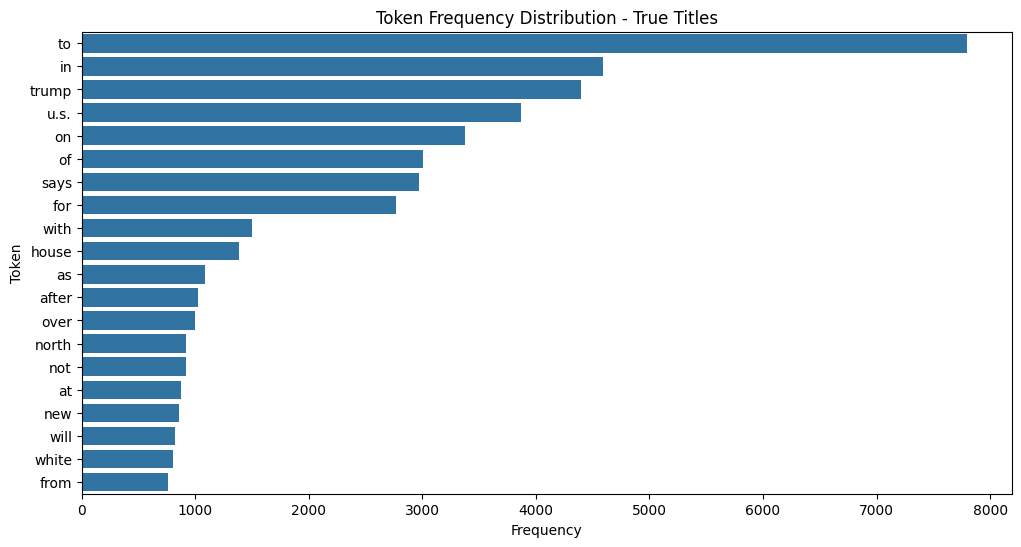

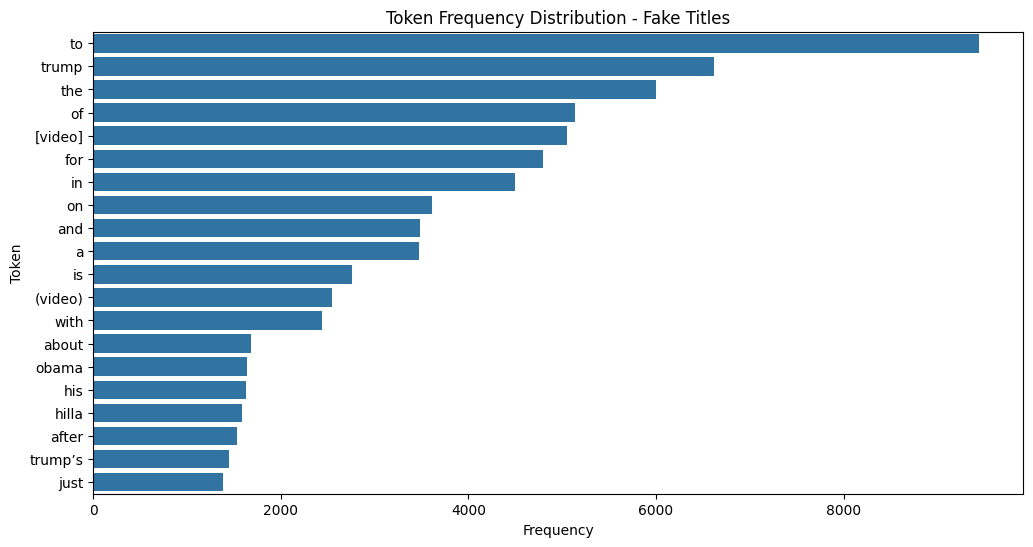

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

def plot_token_frequency_distribution(df, title):
    # count tokenize the lemmatized titles
    tokens = ' '.join(df['lemmatized_title']).split()
    token_counts = Counter(tokens)
    
    # create a dataframe for the token counts
    token_df = pd.DataFrame(token_counts.items(), columns=['Token', 'Frequency'])
    token_df = token_df.sort_values(by='Frequency', ascending=False).head(20)  # Top 20 tokens
    
    # plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Frequency', y='Token', data=token_df)
    plt.title(f'Token Frequency Distribution - {title}')
    plt.xlabel('Frequency')
    plt.ylabel('Token')
    plt.show()
    
# plot for true and fake titles
plot_token_frequency_distribution(true_df, 'True Titles')
plot_token_frequency_distribution(fake_df, 'Fake Titles')

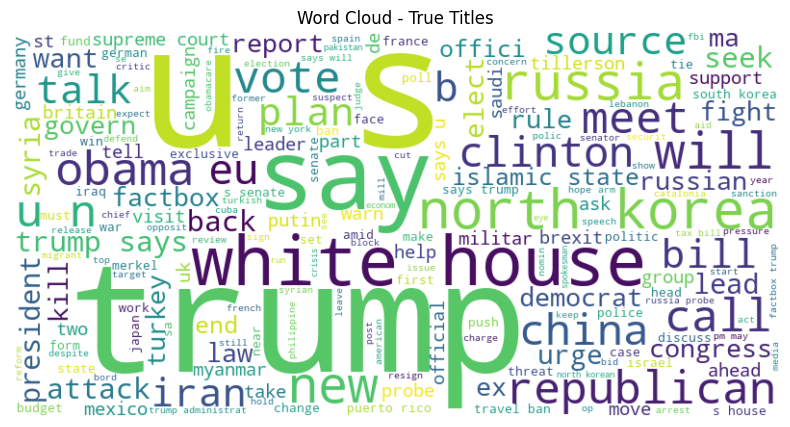

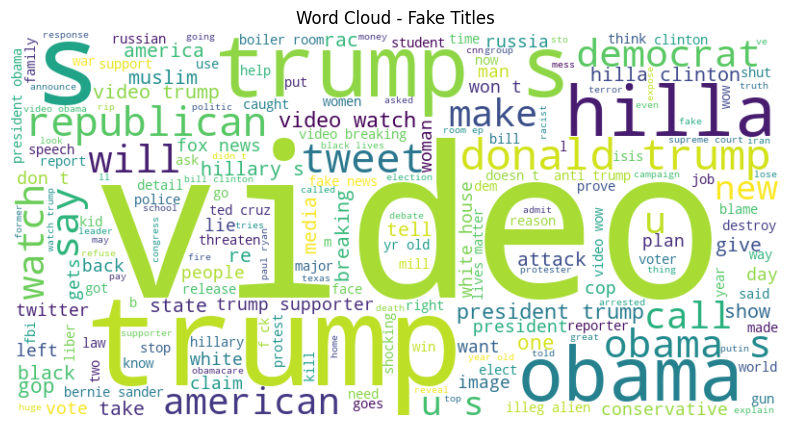

In [15]:
def plot_word_cloud(df, title):
    text = ' '.join(df['lemmatized_title'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {title}')
    plt.show()

# Word clouds for true and fake titles
plot_word_cloud(true_df, 'True Titles')
plot_word_cloud(fake_df, 'Fake Titles')

# Classification: Reports and Visualizations

Bag-of-Words - Naive Bayes Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      4650
           1       0.97      0.96      0.97      4330

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980

Bag-of-Words - SVM Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      4650
           1       0.97      0.98      0.97      4330

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



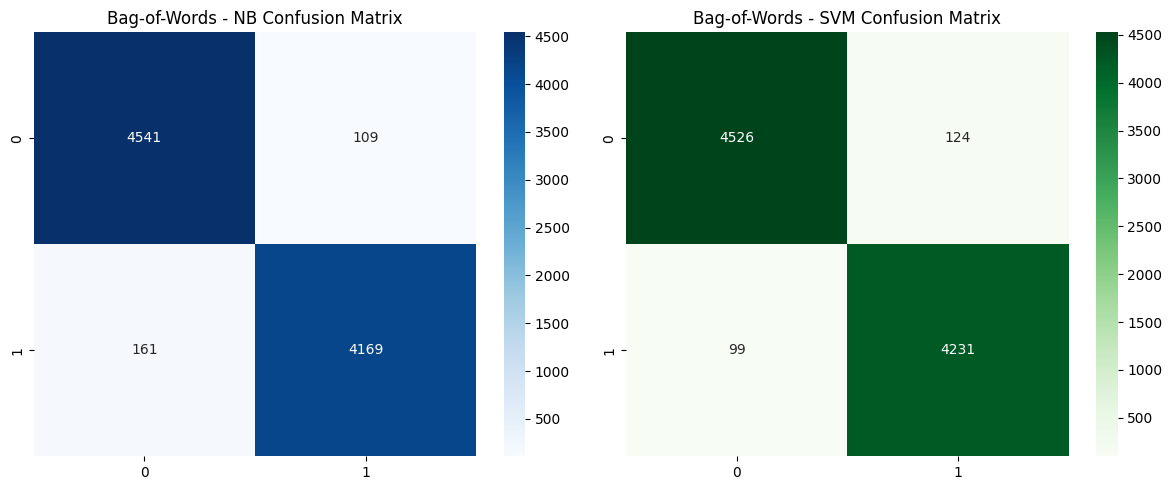

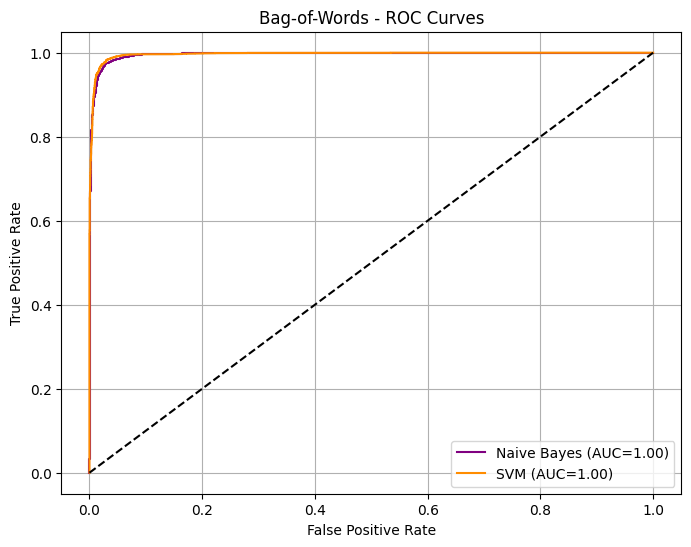

TF-IDF - Naive Bayes Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      4650
           1       0.98      0.95      0.97      4330

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980

TF-IDF - SVM Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      4650
           1       0.97      0.98      0.97      4330

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



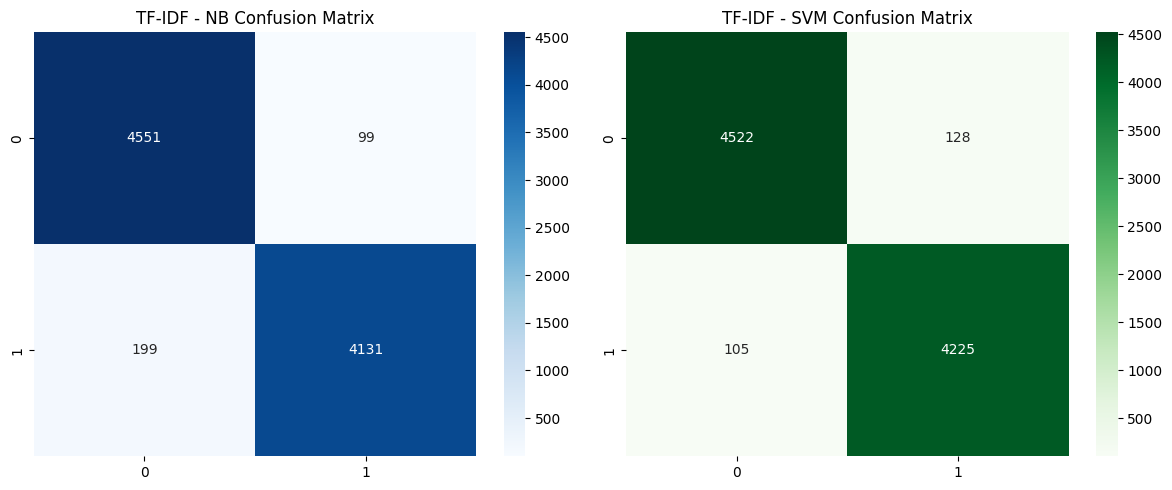

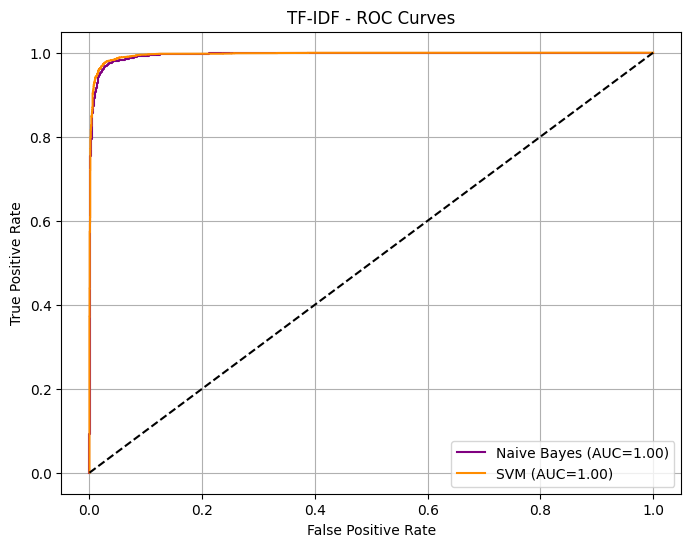

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# combine and label data
true_texts = true_df['lemmatized_title'].tolist()
fake_texts = fake_df['lemmatized_title'].tolist()
all_texts = true_texts + fake_texts
labels = [1]*len(true_texts) + [0]*len(fake_texts)

def evaluate_vectorizer(vectorizer, title):
    X = vectorizer.fit_transform(all_texts)
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

    # Naive Bayes
    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    nb_preds = nb.predict(X_test)
    nb_probs = nb.predict_proba(X_test)[:, 1]

    # SVM
    svc = SVC(kernel='linear', probability=True)
    svc.fit(X_train, y_train)
    svc_preds = svc.predict(X_test)
    svc_probs = svc.predict_proba(X_test)[:, 1]

    # Reports
    print(f"{title} - Naive Bayes Report:\n", classification_report(y_test, nb_preds))
    print(f"{title} - SVM Report:\n", classification_report(y_test, svc_preds))

    # Confusion Matrices
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_test, nb_preds), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{title} - NB Confusion Matrix")
    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test, svc_preds), annot=True, fmt='d', cmap='Greens')
    plt.title(f"{title} - SVM Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # ROC Curves
    fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_probs)
    fpr_svc, tpr_svc, _ = roc_curve(y_test, svc_probs)
    auc_nb = auc(fpr_nb, tpr_nb)
    auc_svc = auc(fpr_svc, tpr_svc)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC={auc_nb:.2f})', color='purple')
    plt.plot(fpr_svc, tpr_svc, label=f'SVM (AUC={auc_svc:.2f})', color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{title} - ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

# call for Bag-of-Words
evaluate_vectorizer(CountVectorizer(), "Bag-of-Words")

# call for TF-IDF
evaluate_vectorizer(TfidfVectorizer(), "TF-IDF")
